# Use data for asteroids that have both SDSS and WISE data,
# and investigate if fig. 15 analysis from the MMI paper can be improved:
## 1) by adding regions to the constant-albedo MMI model  (recycle fig. 15 from MMI)
## 2) using Gaussian Mixture Model (recycle Figs. 10.20 and 10.21 from astroML)
## 3) using Nearest Neighbor Model (recycle Fig. 9.7 from astroML) 
## 4) using resampling with Extreme Deconvolution Model (recycle Fig. 6.11 from astroML) 
 
### This is a cleaned notebook that produces the final figures for the I&I paper.


[Link to data reading](#dataReading) 

[Link to data analysis plots: constant albedo](#dataAnalysis1) 

[Link to data analysis plots: nearest neighbors](#dataAnalysisNN) 


[Link to data analysis plots: GMM](#dataAnalysis2) 

[Link to data analysis plots: XD](#dataAnalysis3) 

In [1]:
%matplotlib inline
import numpy as np 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import scipy 
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
# for astroML installation see https://www.astroml.org/user_guide/installation.html
from astroML.plotting import hist
from astroML.utils.decorators import pickle_results 
from astroML.density_estimation import XDGMM

In [51]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing Ved's tools (in the same directory as this notebook): 
import plottingTools as vpt
import analysisTools as vat 
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='dataReading'></a>

### Define paths and catalogs 

In [3]:
# you may want to move fig15_data.csv to the same directory as this notebook
dataDir = "data"
# data dump for fig. 15 from the MMI paper (produced by Joachim Moeyens)
SDSSWISEfile = dataDir + "/" + "fig15_data.csv"

In [4]:
# describe data structure
colnames = ['ID', 'mjd', 'mjdMOC', 'u', 'g', 'r', 'i', 'z', 
            'Hmag', 'Vsdss', 'pV', 'pVsdss', 'Ratm', 'Rsdss', 
            'phaseatm', 'phasesdss', 'logDatm']

In [5]:
dataAll = Table.read(SDSSWISEfile, format='csv', names=colnames) 
# we want to add a bit of random noise to magnitudes to avoid aliasing in plots
vat.randomizePhotometry(dataAll, 0.005)
vat.assignColors(dataAll)
np.size(dataAll)

1574

In [6]:
# reject a few (17) objects with lousy photometry by reject outliers in colors 
data = dataAll[(dataAll['g-r']<1.0)&(dataAll['r-i']<1.0)&(dataAll['i-z']<1.0)]
print(np.size(dataAll), np.size(data))

1574 1557


In [7]:
# the original constant-albedo model with 3 regions 
vat.assignModelAlbedo(data, "constRegAlbedoMMI", 'pMMI')
print('sigG(Drat):', vat.sigG(np.sqrt(data['pV']/data['pMMI'])))

0.05218463575838207
0.07803567008888478
0.20445808418551895
sigG(Drat): 0.17741529731125896


In [8]:
# the improved constant-albedo model with 4 regions 
vat.assignModelAlbedo(data, "constRegAlbedo", 'pVII')
print('sigG(Drat):', vat.sigG(np.sqrt(data['pV']/data['pVII'])))

0.05218463575838207
0.05328291116904438
0.20445808418551895
0.12192267216332717
sigG(Drat): 0.15393107712154908


<a id='dataAnalysis1'></a>
## Constant Albedo Model  

In [9]:
print('sigG(Drat) MMI:', vat.sigG(np.sqrt(data['pV']/data['pMMI'])))
print('sigG(Drat) I&I:', vat.sigG(np.sqrt(data['pV']/data['pVII'])))

sigG(Drat) MMI: 0.17741529731125896
sigG(Drat) I&I: 0.15393107712154908


22 values are outside the defined minimum and maximum.
mu : 0.914
sigma : 0.680
weight : 1.000
58 values are outside the defined minimum and maximum.
mu : 0.993
sigma : 0.165
weight : 1.000

saved plot as: quadPlot.png


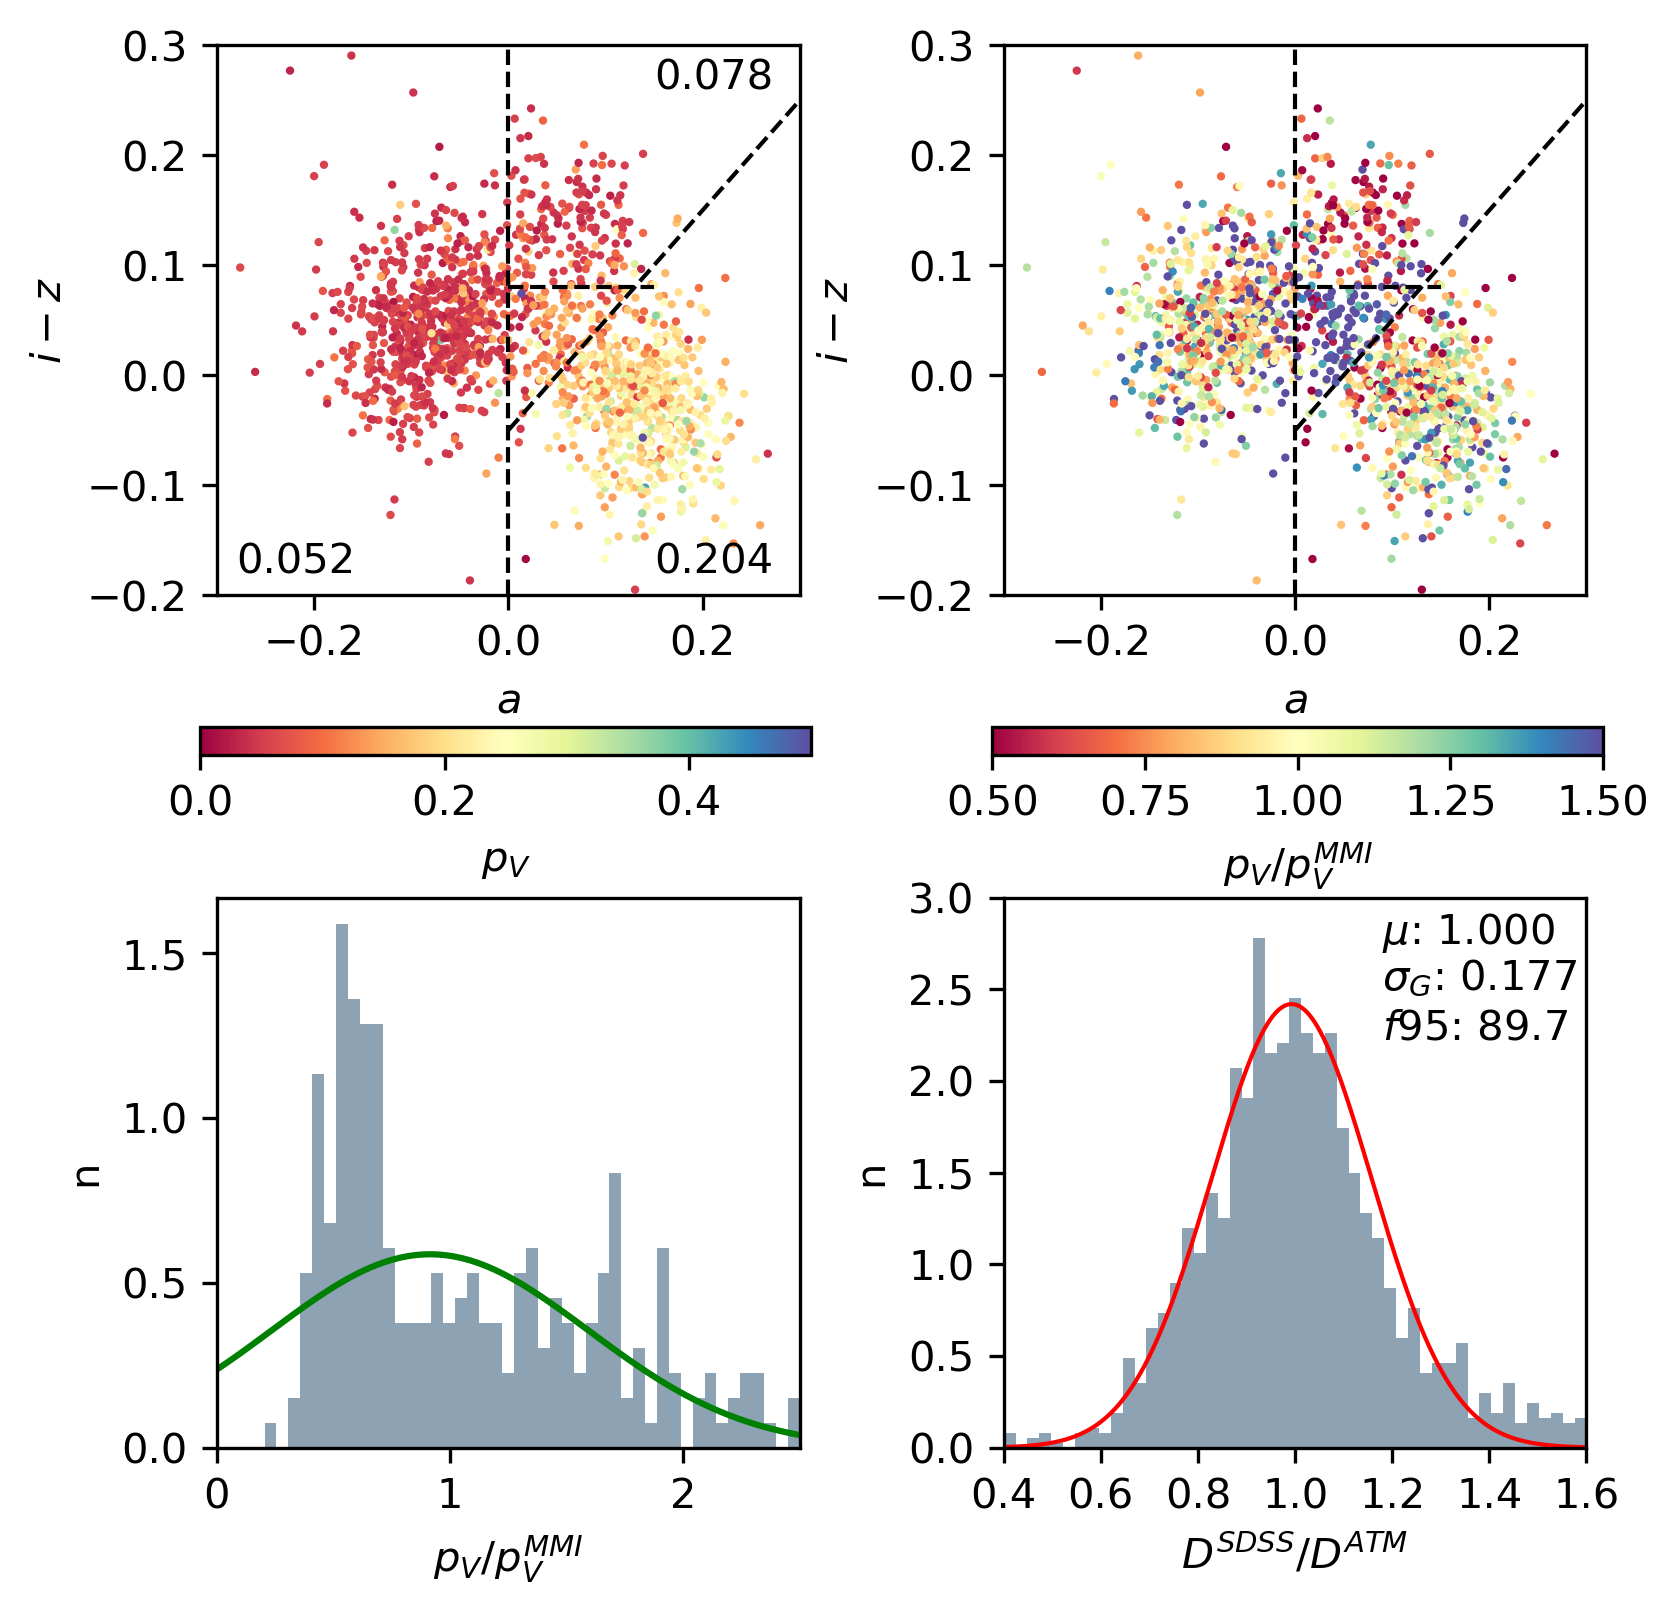

In [10]:
data['pVrat'] = data['pV']/data['pMMI']
Drat = np.sqrt(data['pVrat'])
vpt.quadPlots(data, Drat)

saved plot as: twoPanels_colors_pV.png


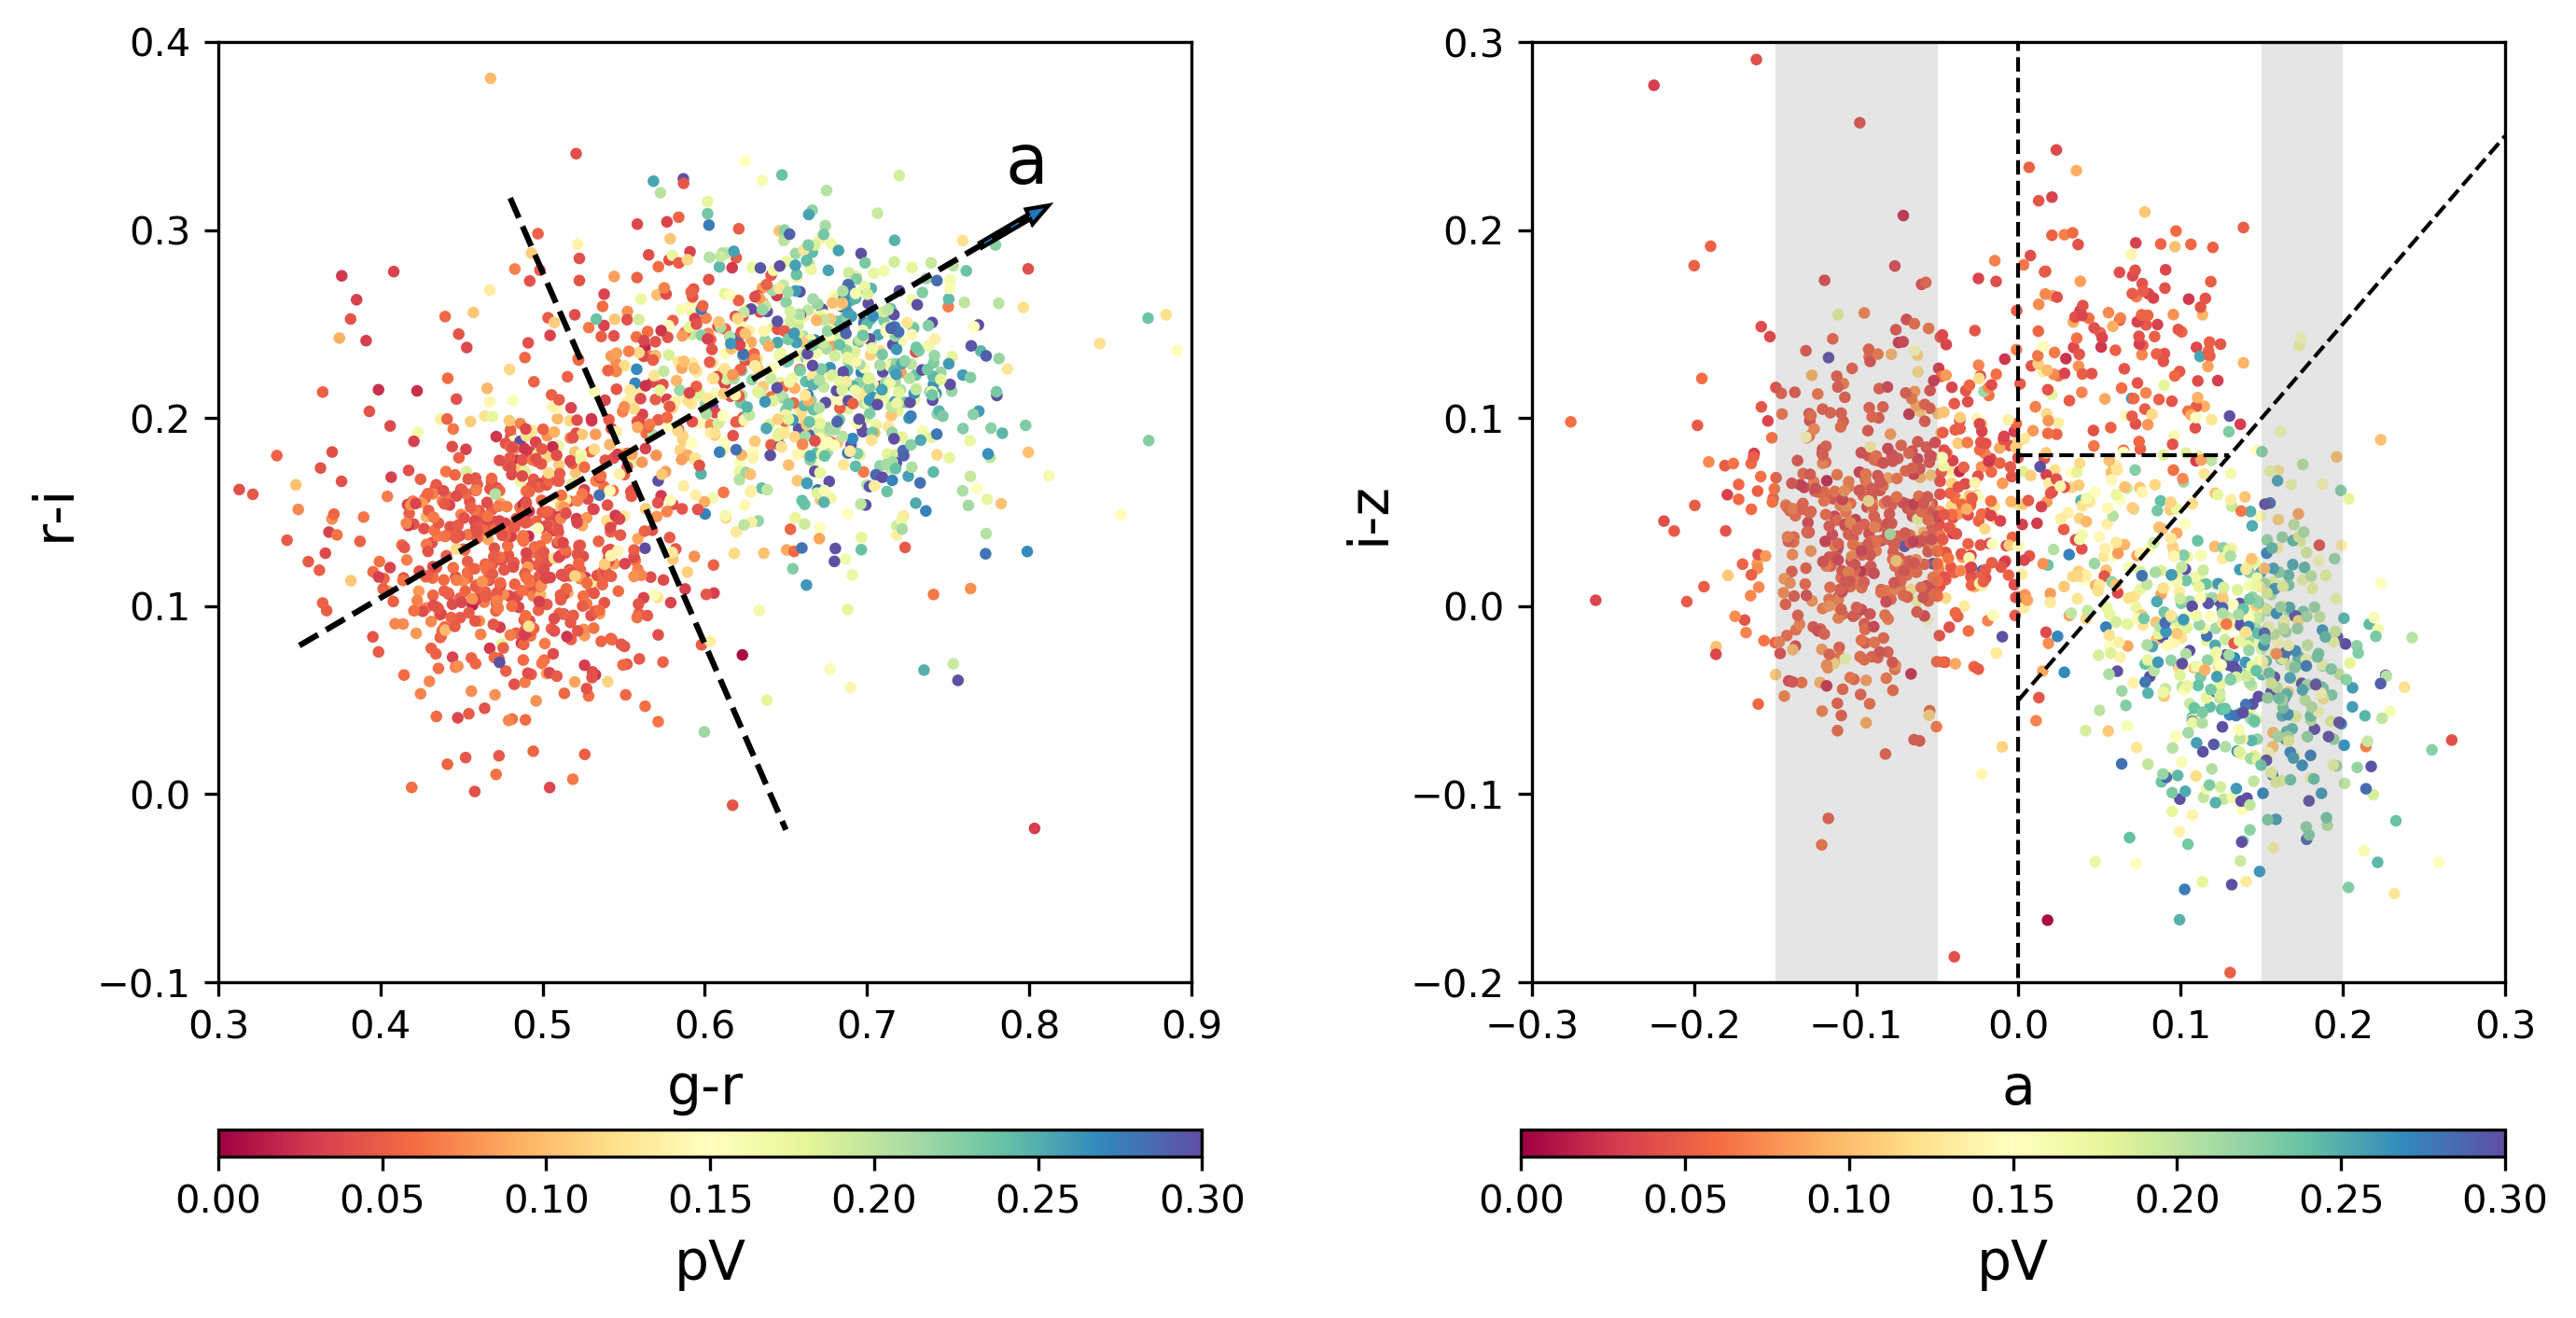

In [93]:
keywords = {"Xstr1":'g-r', "Xmin1":0.3, "Xmax1":0.9, \
            "Ystr1":'r-i', "Ymin1":-0.1, "Ymax1":0.4, \
            "Cstr1":'pV', "Cmin1":0.0, "Cmax1":0.3, "Clabel1":'pV', \
            "Xstr2":'a', "Xmin2":-0.3, "Xmax2":0.3, \
            "Ystr2":'i-z', "Ymin2":-0.2, "Ymax2":0.3, \
            "Cstr2":'pV', "Cmin2":0.0, "Cmax2":0.3, "Clabel2":'pV',
            "symbSize":4.0, "plotName":'twoPanels_colors_pV.png'}
data['a'] = data['a_color']
import plottingTools as vpt
vpt.twoPanelsPlot(data, keywords, plotShaded=True)

saved plot as: twoPanels_izacolor_pVrat_MMI_VII.png


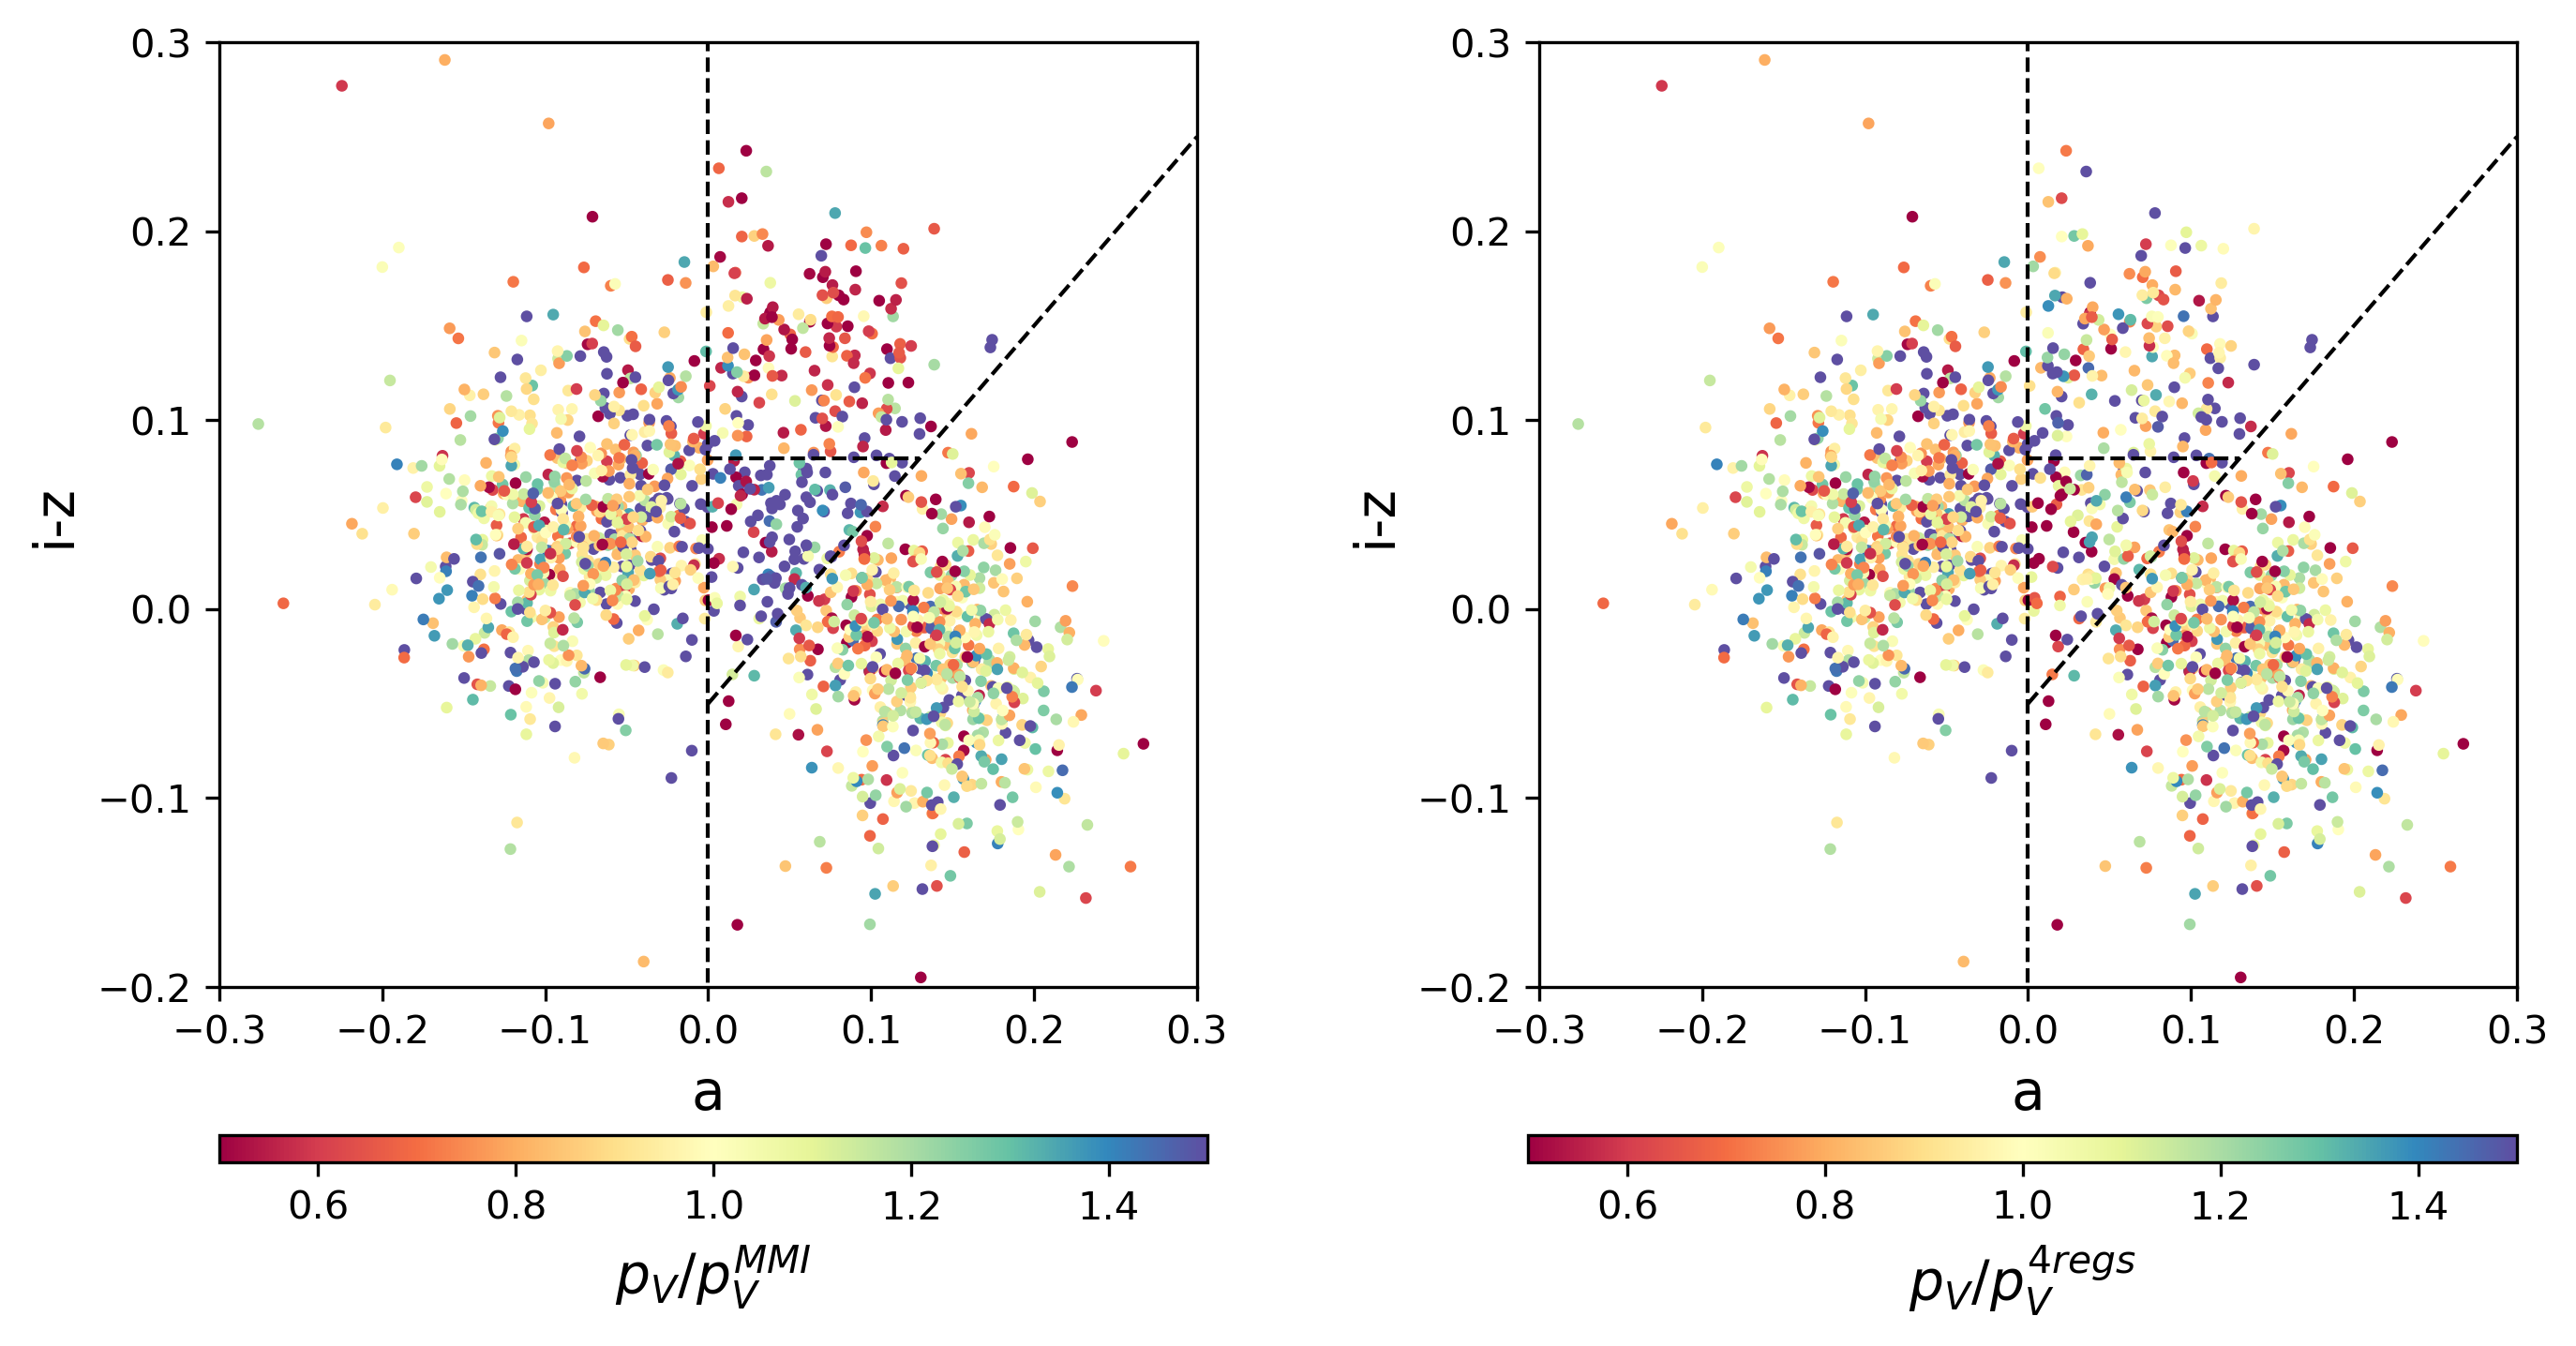

In [12]:
data['pVratMMI'] = data['pV'] / data['pMMI']
data['pVratII'] = data['pV'] / data['pVII']
keywords = {"Xstr1":'a', "Xmin1":-0.3, "Xmax1":0.3, \
            "Ystr1":'i-z', "Ymin1":-0.2, "Ymax1":0.3, \
            "Cstr1":'pVratMMI', "Cmin1":0.5, "Cmax1":1.5, "Clabel1":'$p_V/p_V^{MMI}$', \
            "Xstr2":'a', "Xmin2":-0.3, "Xmax2":0.3, \
            "Ystr2":'i-z', "Ymin2":-0.2, "Ymax2":0.3, \
            "Cstr2":'pVratII', "Cmin2":0.5, "Cmax2":1.5, "Clabel2":'$p_V/p_V^{4regs}$', \
            "symbSize":4.0, "plotName":'twoPanels_izacolor_pVrat_MMI_VII.png'}
vpt.twoPanelsPlot(data, keywords)

<a id='dataAnalysisNN'></a>
## Nearest Neighbors Model 

In [13]:
# setup list of coordinates (colors)
c1 = data['g']-data['r']
c2 = data['r']-data['i']
c3 = data['i']-data['z']
c1Err = c2Err = c3Err = 0.02 + 0*c1
myCoords = (c1, c2, c3)
pV = data['pV'] 

In [14]:
# return Nnn nearest neighbors
Nnn = 3 
pVmodel, sigGDrat = vat.getpVmodel(myCoords, pV, Nnn, 1)
pVratNN = pV/pVmodel
data['pVratNN3'] = pVratNN
print(sigGDrat)

0.18655915947206916


In [15]:
Nnn = 10 
pVmodel, sigGDrat = vat.getpVmodel(myCoords, pV, Nnn, 1)
pVratNN = pV/pVmodel
data['pVratNN10'] = pVratNN
print(sigGDrat)

0.171959609627813


In [16]:
Nnn = 20 
pV = data['pV'] 
pVmodel, sigGDrat = vat.getpVmodel(myCoords, pV, Nnn, 1)
pVratNN = pV/pVmodel
data['pVratNN20'] = pVratNN
print(sigGDrat)

0.17049586926053487


In [17]:
for i in range(3, 21):
    pV1, sig1 = vat.getpVmodel(myCoords, pV, i, 1)
    print(i, sig1) 

3 0.18655915947206916
4 0.18164755456794773
5 0.17334052383738205
6 0.1738036488392826
7 0.17203385331459226
8 0.1685971835891676
9 0.16995935313606986
10 0.171959609627813
11 0.16949628160144964
12 0.16884995648850354
13 0.1690285018101561
14 0.1715702933559345
15 0.17061955127103995
16 0.1714319179096603
17 0.17158950233031753
18 0.1741926584819603
19 0.17216909936645017
20 0.17049586926053487


saved plot as: twoPanels_izacolor_pVrat_NNdata_3_20.png


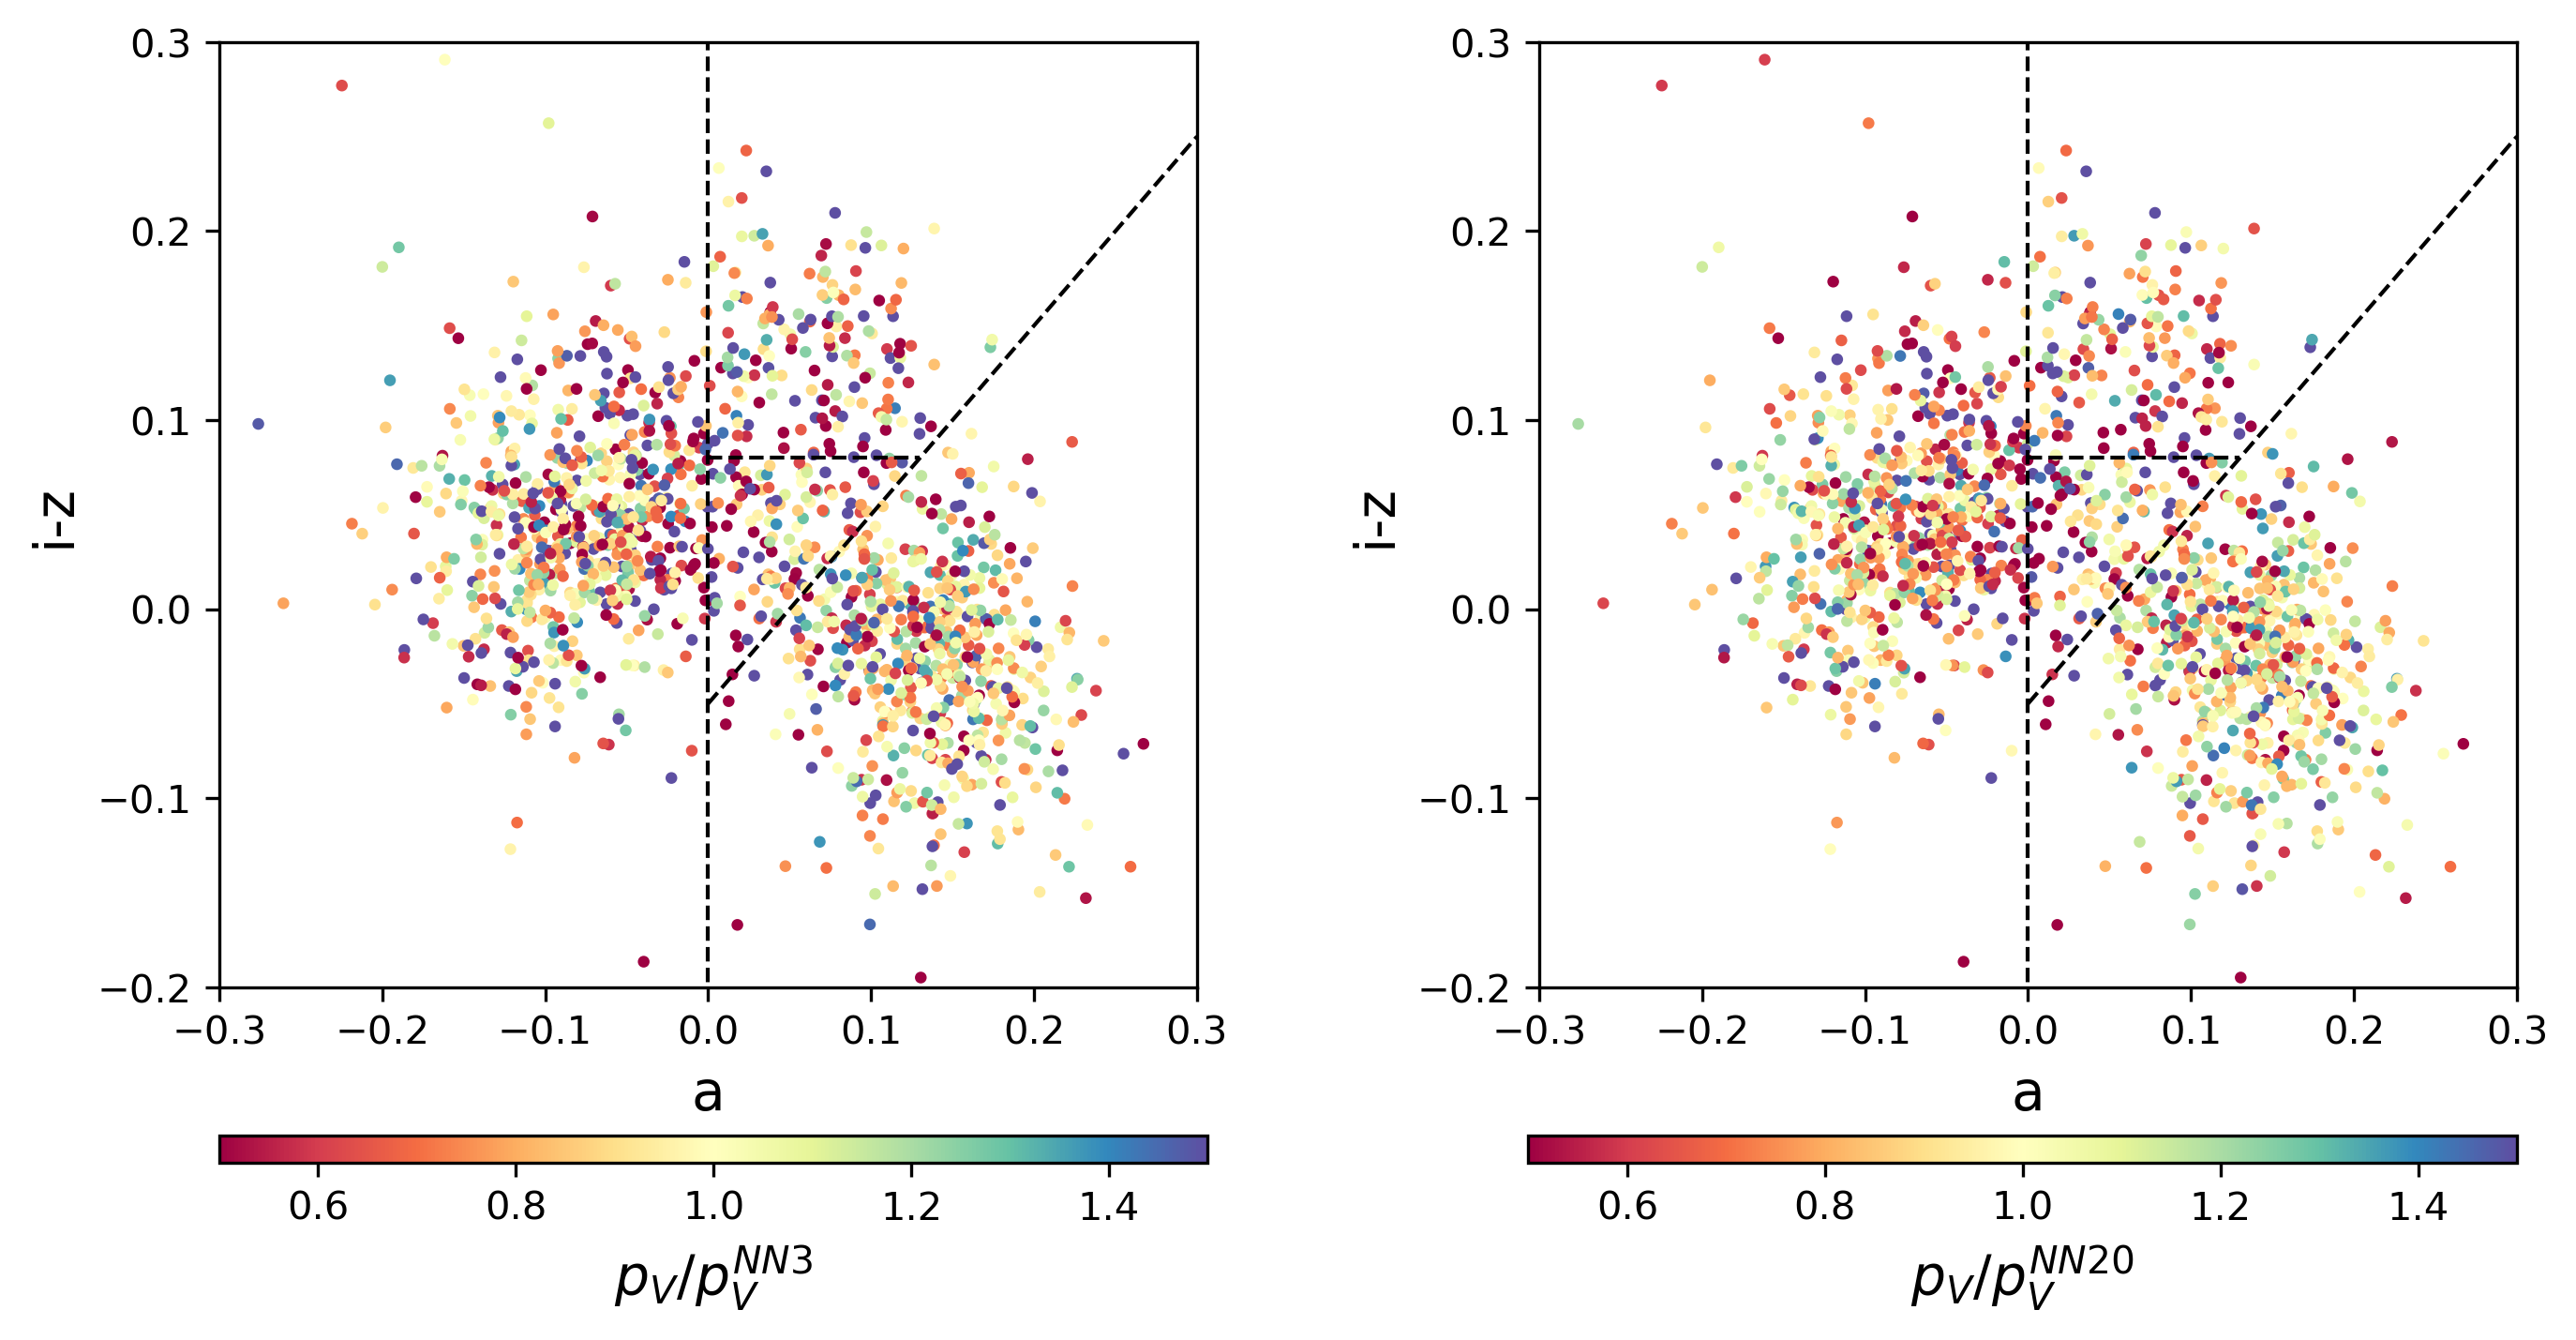

In [18]:
keywords = {"Xstr1":'a', "Xmin1":-0.3, "Xmax1":0.3, \
            "Ystr1":'i-z', "Ymin1":-0.2, "Ymax1":0.3, \
            "Cstr1":'pVratNN3', "Cmin1":0.5, "Cmax1":1.5, "Clabel1":'$p_V/p_V^{NN3}$', \
            "Xstr2":'a', "Xmin2":-0.3, "Xmax2":0.3, \
            "Ystr2":'i-z', "Ymin2":-0.2, "Ymax2":0.3, \
            "Cstr2":'pVratNN20', "Cmin2":0.5, "Cmax2":1.5, "Clabel2":'$p_V/p_V^{NN20}$', \
            "symbSize":4.0, "plotName":'twoPanels_izacolor_pVrat_NNdata_3_20.png'}
vpt.twoPanelsPlot(data, keywords)

<a id='dataAnalysis2'></a>
## Gaussian Mixture Model, see
#### https://www.astroml.org/book_figures/chapter10/fig_LINEAR_clustering.html

In [19]:
att = [('a_color', 'i-z', 'pV')] 
comp = np.arange(1, 21)
nGMMclass, cnts, means, stddevs = vat.doGMM(data, att, comp, 'GMMclass')

  - 1 component fit
  - 2 component fit
  - 3 component fit
  - 4 component fit
  - 5 component fit
  - 6 component fit
  - 7 component fit
  - 8 component fit
  - 9 component fit
  - 10 component fit
  - 11 component fit
  - 12 component fit
  - 13 component fit
  - 14 component fit
  - 15 component fit
  - 16 component fit
  - 17 component fit
  - 18 component fit
  - 19 component fit
  - 20 component fit


In [20]:
for i in (np.unique(data['GMMclass'])): print(i, np.size(data[data['GMMclass']==i]))

0 481
1 1
2 589
3 201
4 63
5 221
6 1


saved plot as: threePanels_colors_GMM.png


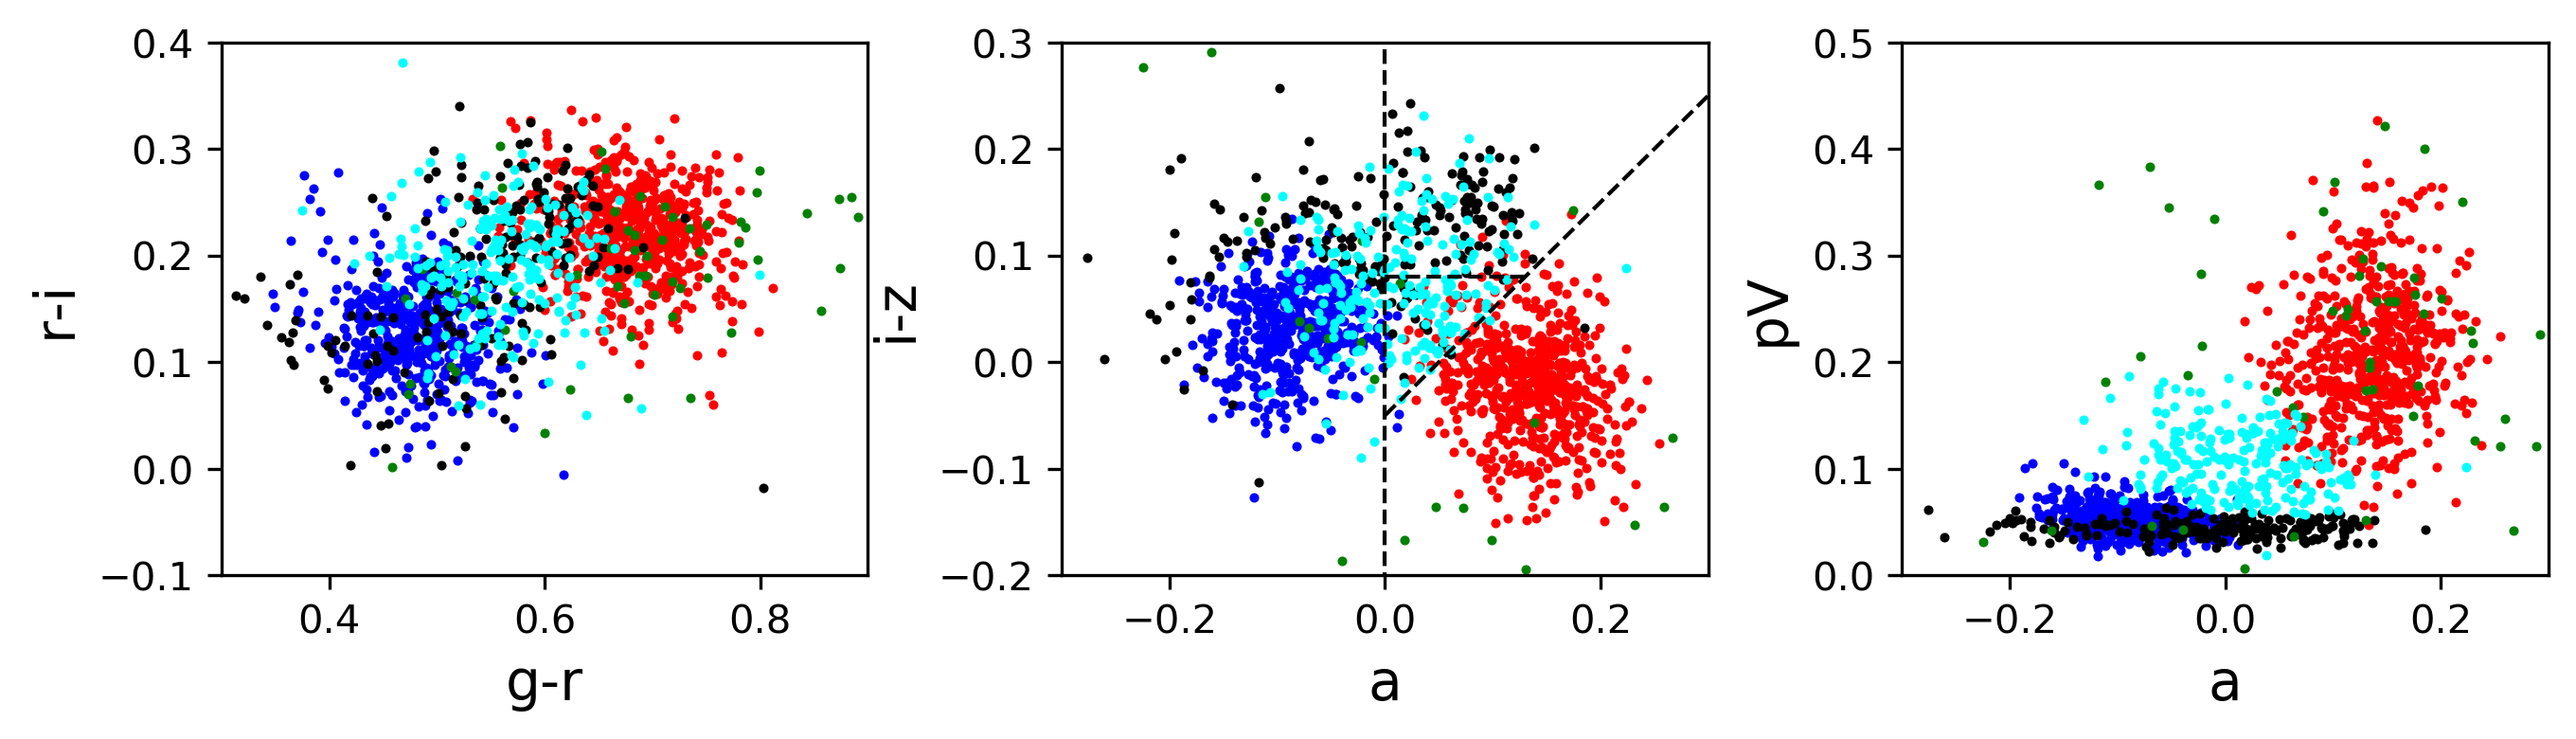

In [21]:
classColors = ['blue', 'noplot', 'red', 'black', 'green', 'cyan', 'noplot']
nClasses = 7
keywords = {"Xstr1":'g-r', "Xmin1":0.3, "Xmax1":0.9, \
            "Ystr1":'r-i', "Ymin1":-0.1, "Ymax1":0.4, \
            "Xstr2":'a', "Xmin2":-0.3, "Xmax2":0.3, \
            "Ystr2":'i-z', "Ymin2":-0.2, "Ymax2":0.3, \
            "Xstr3":'a', "Xmin3":-0.3, "Xmax3":0.3, \
            "Ystr3":'pV', "Ymin3":0.0, "Ymax3":0.5, \
            "symbSize":2.0, "plotName":'threePanels_colors_GMM.png', \
            "classVec":'GMMclass', "classCount":nClasses}
data['a'] = data['a_color'] 
vpt.discrete3PanelsPlot(data, classColors, keywords)

In [22]:
# setup list of coordinates (colors)
c1 = data['g']-data['r']
c2 = data['r']-data['i']
c3 = data['i']-data['z']
c1Err = c2Err = c3Err = 0.02 + 0*c1
myCoords = (c1, c2, c3)
pV = data['pV'] 
# return Nnn nearest neighbors
Nnn = 10 
pVmodel, sigGDrat = vat.getpVmodel(myCoords, pV, Nnn, 1)
pVratNN = pV/pVmodel
data['pVratNN'] = pVratNN
print(sigGDrat)

0.171959609627813


<a id='dataAnalysis2'></a>
## Extreme Deconvolution Model, see
#### https://www.astroml.org/book_figures/chapter6/fig_XD_example.html

In [23]:
# compute and save results
@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    clf = XDGMM(n_components, max_iter=max_iter)
    clf.fit(X, Xerr)
    return clf

In [24]:
# stack the results for computation
x = data['g-r']
y = data['r-i']
z = data['i-z']
w = data['pV']
# typical SDSS photometric errors 
dx = 0.02 + 0*x
dy = 0.02 + 0*y
dz = 0.02 + 0*z
# estimate of pV errors (assuming 5% for Derr and 0.05 mag for Herr)
dw = 0.11*w
# pack into the format assumed by compute_XD_results below
X = np.vstack([x, y, z, w]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2, dz ** 2, dw ** 2]).T

In [25]:
# remove file XD_toy.pkl to force it to recompute...
# file saved as XD_toy_11percpV2percColors.pkl produced here 
recompute = False
if (recompute):
    !rm XD_toy.pkl
    clfXD = compute_XD_results(10, 500)
    !cp 'XD_toy.pkl' 'XD_toy_11percpV2percColors.pkl'
else:
    !cp 'XD_toy_11percpV2percColors.pkl' 'XD_toy.pkl' 
    clfXD = compute_XD_results(10, 500)

@pickle_results: using precomputed results from 'XD_toy.pkl'


In [26]:
# clone a sample of 500,000 objects
sampleXD = clfXD.sample(500000)
grXD = sampleXD[:,0]
riXD = sampleXD[:,1]
izXD = sampleXD[:,2]
pVXD = sampleXD[:,3]
acolorXD = 0.89 * grXD + 0.45 * riXD - 0.57

In [27]:
# for SDSS, we used above a typical color error of 0.02 mag
errSDSS = 0.02 
grSDSS, riSDSS, izSDSS, acolorSDSS = vat.addErrors(grXD, riXD, izXD, errSDSS)
# for LSST, assuming no light curve fitting, the worst expected error is 0.05 mag 
errLSST = 0.05 
grLSST, riLSST, izLSST, acolorLSST = vat.addErrors(grXD, riXD, izXD, errLSST)
# but if light curves are well fit, then errors of 0.01 mag are possible
errLSSTlc = 0.01
grLSSTlc, riLSSTlc, izLSSTlc, acolorLSSTlc = vat.addErrors(grXD, riXD, izXD, errLSSTlc)

In [28]:
# given 500,000 simulated asteroids, we can minimize noise by using many neighbors
Nnn = 100 
c1 = data['g-r'] 
c2 = data['r-i'] 
c3 = data['i-z'] 
myCoords = (c1, c2, c3)
pV = data['pV']

# first estimate the performance for the SDSS-WISE dataset
coordsSample = (grSDSS, riSDSS, izSDSS)
pVmodelSDSS, sigGDratSDSS = vat.getpVmodelSample(myCoords, pV, coordsSample, pVXD, Nnn, 0)
# for assessing the impact of matching color errors
coordsSample = (grXD, riXD, izXD)
pVmodelS, sigGDratS = vat.getpVmodelSample(myCoords, pV, coordsSample, pVXD, Nnn, 0)
print(sigGDratS, sigGDratSDSS)

0.14852500690823042 0.15302485647492786


In [29]:
# to study the impact of photometric errors, clone a sample of similar size as the dataset
sampleXDE = clfXD.sample(1500)
grXDE = sampleXDE[:,0]
riXDE = sampleXDE[:,1]
izXDE = sampleXDE[:,2]
pVXDE = sampleXDE[:,3]
acolorXDE = 0.89 * grXDE + 0.45 * riXDE - 0.57
c1e = grXDE
c2e = riXDE
c3e = izXDE
myCoordsE = (c1e, c2e, c3e)
pVe = np.where(pVXDE > 0.01, pVXDE, 0.01)

In [30]:
# three versions, for three different levels of magnitude errors 
Nnn = 100 
coordsSample = (grXD, riXD, izXD)
pVmodelSe, sigGDratSe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSample = (grSDSS, riSDSS, izSDSS)
pVmodelSDSSe, sigGDratSDSSe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSample = (grLSST, riLSST, izLSST)
pVmodelLSSTe, sigGDratLSSTe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSampl = (grLSSTlc, riLSSTlc, izLSSTlc)
pVmodelLSSTlce, sigGDratLSSTlce = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
# ordered by assumed photometric errors
print(sigGDratSe, sigGDratLSSTlce, sigGDratSDSSe, sigGDratLSSTe)

0.12875810908550822 0.14609934956912998 0.13473197324608832 0.14609934956912998


In [31]:
# three versions, for three different levels of magnitude errors 
Nnn = 10
coordsSample = (grXD, riXD, izXD)
pVmodelSe, sigGDratSe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSample = (grSDSS, riSDSS, izSDSS)
pVmodelSDSSe, sigGDratSDSSe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSample = (grLSST, riLSST, izLSST)
pVmodelLSSTe, sigGDratLSSTe = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
coordsSampl = (grLSSTlc, riLSSTlc, izLSSTlc)
pVmodelLSSTlce, sigGDratLSSTlce = vat.getpVmodelSample(myCoordsE, pVe, coordsSample, pVXD, Nnn, 0)
# ordered by assumed photometric errors
print(sigGDratSe, sigGDratLSSTlce, sigGDratSDSSe, sigGDratLSSTe)

0.13529404342554557 0.1469639509535194 0.13965213030913295 0.1469639509535194


In [32]:
# make the plots 
dataXD = Table()
dataXD['g-r'] = sampleXD[:,0]
dataXD['r-i'] = sampleXD[:,1] 
dataXD['i-z'] = sampleXD[:,2] 
dataXD['a_color'] = 0.89 * dataXD['g-r'] + 0.45 * dataXD['r-i'] - 0.57
dataXD['pV'] = sampleXD[:,3] 
# select only those within plotted limits
flagOK = ((dataXD['a_color']>-0.3) & (dataXD['a_color']<0.3))
flagOK = (flagOK & (dataXD['i-z']>-0.2) & (dataXD['i-z']<0.3))
flagOK = (flagOK & (dataXD['pV']>0.0) & (dataXD['pV']<0.5))
dataOK = dataXD[flagOK] 

saved plot as: XDcountourplot.png


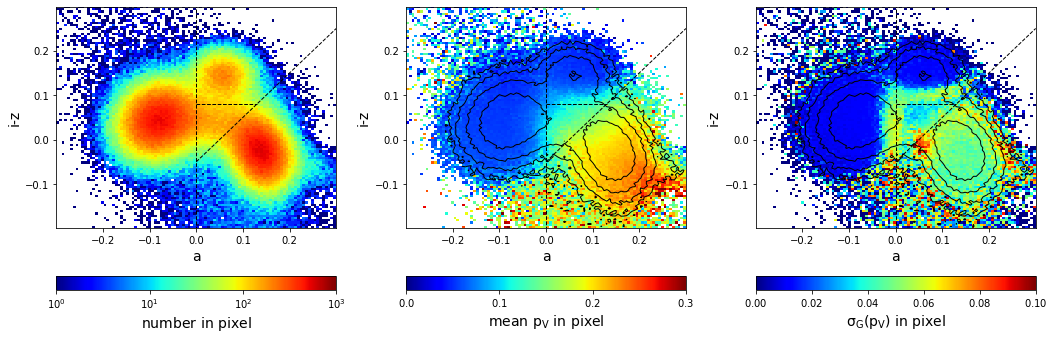

In [33]:
vpt.XDcontourplot(dataOK['a_color'], dataOK['i-z'], dataOK['pV'])

saved plot as: XDcountourplot4panels.png


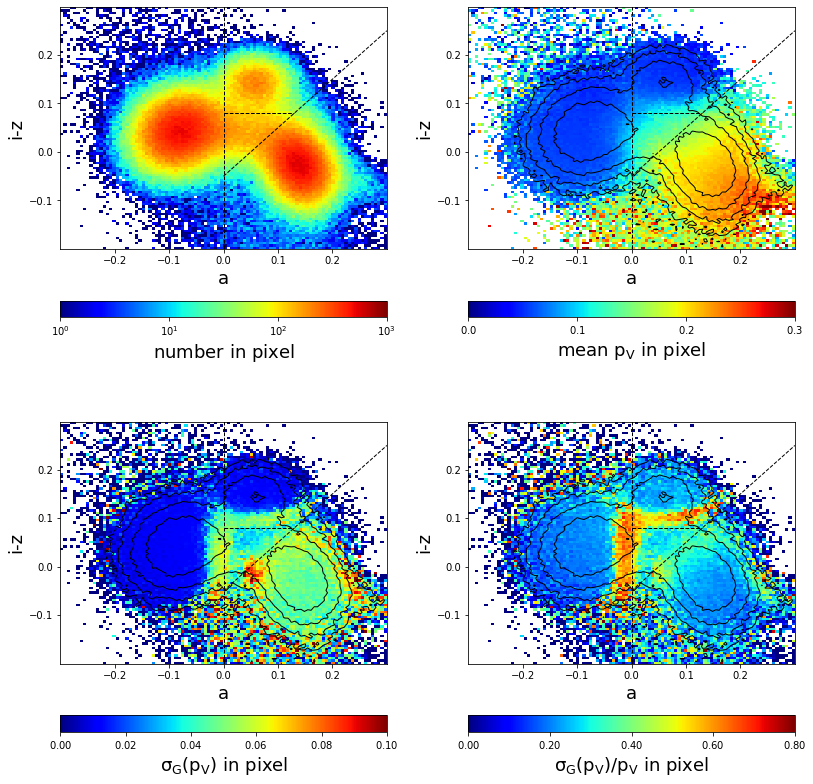

In [75]:
### plot the 4-panel version suggested by the referee
vpt.XDcontourplot4panels(dataOK['a_color'], dataOK['i-z'], dataOK['pV'])

saved plot as: twoPanels_izacolor_pVrat_XD.png


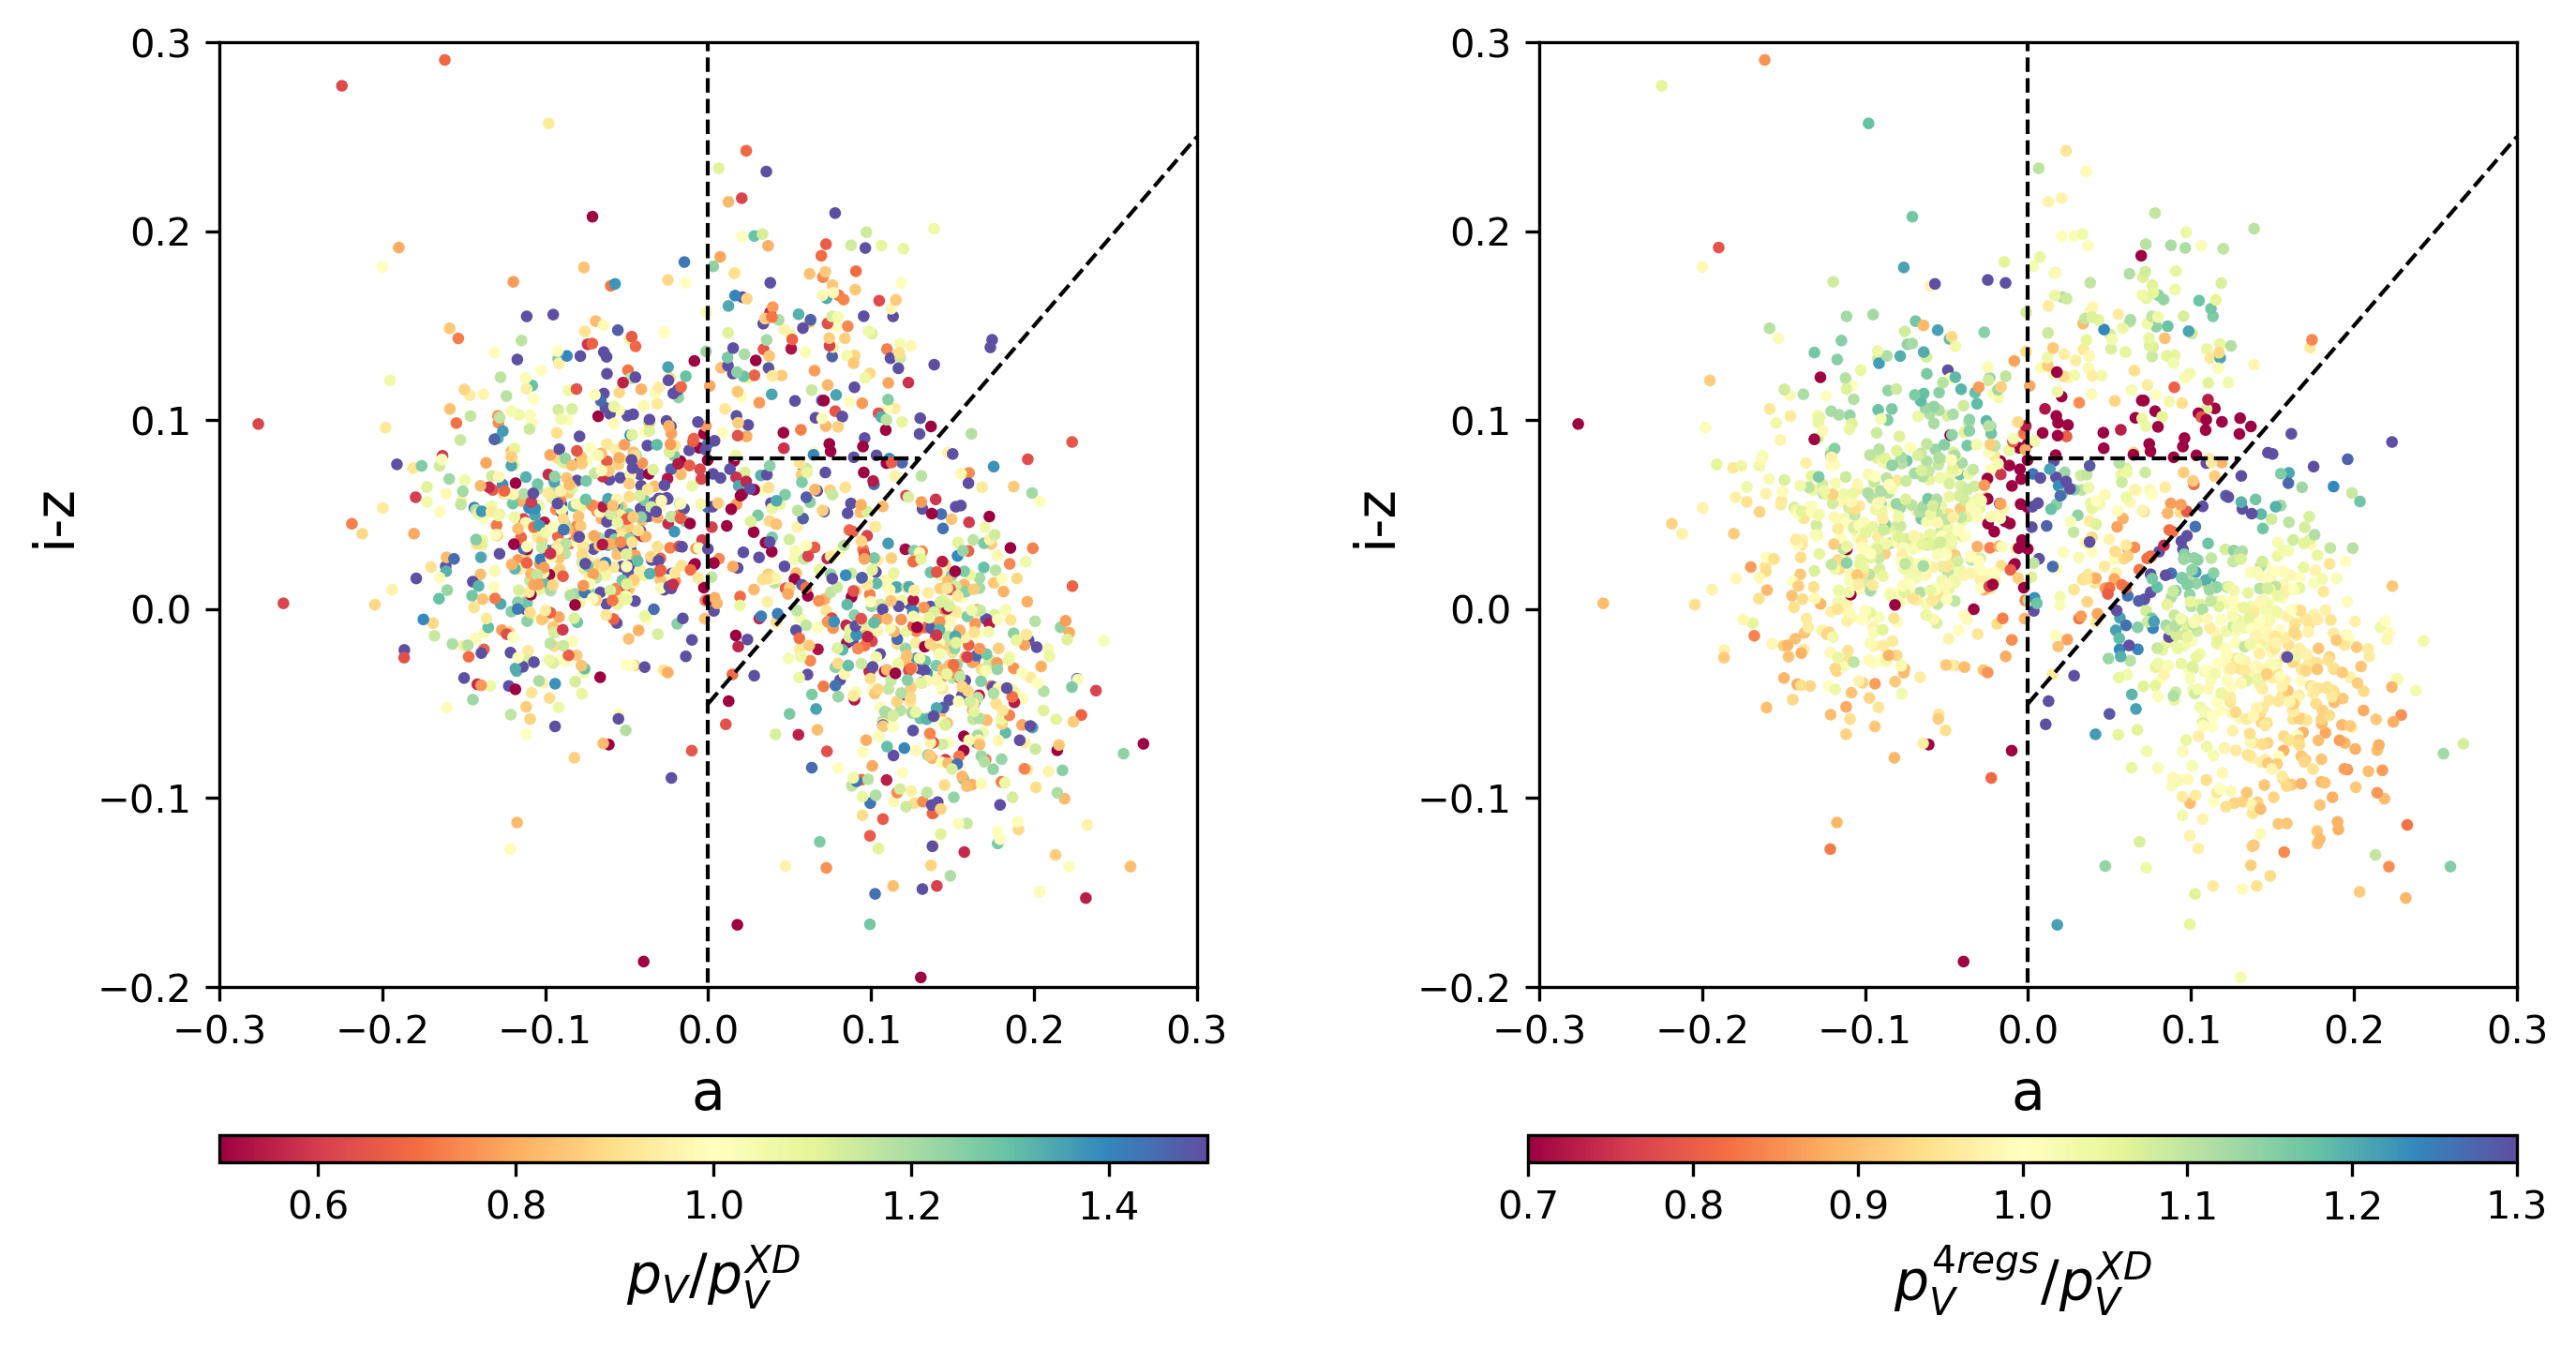

In [34]:
data['pVratXD'] = data['pV']/pVmodelSDSS 
data['pVmodelRat'] = data['pVII']/pVmodelSDSS 
data['a'] = data['a_color']
keywords = {"Xstr1":'a', "Xmin1":-0.3, "Xmax1":0.3, \
            "Ystr1":'i-z', "Ymin1":-0.2, "Ymax1":0.3, \
            "Cstr1":'pVratXD', "Cmin1":0.5, "Cmax1":1.5, "Clabel1":'$p_V/p_V^{XD}$', \
            "Xstr2":'a', "Xmin2":-0.3, "Xmax2":0.3, \
            "Ystr2":'i-z', "Ymin2":-0.2, "Ymax2":0.3, \
            "Cstr2":'pVmodelRat', "Cmin2":0.7, "Cmax2":1.3, "Clabel2":'$p_V^{4regs}/p_V^{XD}$', \
            "symbSize":4.0, "plotName":'twoPanels_izacolor_pVrat_XD.png'}
vpt.twoPanelsPlot(data, keywords)

<a id='dataAnalysis3'></a>
## Apply Extreme Deconvolution Model to the full WISE-SDSS sample 

In [35]:
dataDir = "data"
MOCW3file = dataDir + "/" + "MOC_W3.csv"
dataMOCall = Table.read(MOCW3file, format='csv')

In [36]:
dataMOC = dataMOCall[(dataMOCall['g-r']<1.0)&(dataMOCall['r-i']<1.0)&(dataMOCall['i-z']<1.0)&(dataMOCall['mag_W3_median']<10)]
print(np.size(dataMOCall), np.size(dataMOC))

53634 42333


In [37]:
bands = ('u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag') 
vat.randomizePhotometry(dataMOC, 0.005, bands)
dataMOC['g-r'] = dataMOC['g_mag'] - dataMOC['r_mag'] 
dataMOC['r-i'] = dataMOC['r_mag'] - dataMOC['i_mag'] 
dataMOC['i-z'] = dataMOC['i_mag'] - dataMOC['z_mag'] 
dataMOC['a_color'] = 0.89 * dataMOC['g-r'] + 0.45 * dataMOC['r-i'] - 0.57

In [38]:
# the improved constant-albedo model with 4 regions 
dataMOC['pV'] = dataMOC['pv']
vat.assignModelAlbedo(dataMOC, "constRegAlbedo", 'pVII')
dataMOC['pVrat'] = dataMOC['pV']/dataMOC['pVII'] 
print('sigG(Drat):', vat.sigG(np.sqrt(dataMOC['pVrat'])))

0.058269578683197265
0.08727167937656888
0.2388385714309952
0.14728413974031382
sigG(Drat): 0.21967716883061544


In [39]:
# implied pV error for the large sample
np.sqrt(0.2198**2 - 0.1539**2)

0.15692937902126547

In [40]:
# stack the results for computation
x = dataMOC['g-r']
y = dataMOC['r-i']
z = dataMOC['i-z']
w = dataMOC['pV']
# typical SDSS photometric errors 
dx = 0.02 + 0*x
dy = 0.02 + 0*y
dz = 0.02 + 0*z
# estimate of pV errors (assuming 10% for Derr and 0.05 mag for Herr), see Sec. 2.1 in the I&I paper
dw = 0.20*w
# pack into the format assumed by compute_XD_results below
X = np.vstack([x, y, z, w]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2, dz ** 2, dw ** 2]).T

In [41]:
# remove file XD_toy.pkl to force it to recompute...
# file saved as XD_toy_11percpV2percColors.pkl contains high-quality results used in the I&I paper
# file saved as XD_toy_fullSDSSWISE.pkl produced here 
recompute = False
if (recompute):
    !rm XD_toy.pkl
    clfXDfull = compute_XD_results(10, 500)
    !cp 'XD_toy.pkl' 'XD_toy_fullSDSSWISE.pkl'
else:
    !cp 'XD_toy_fullSDSSWISE.pkl' 'XD_toy.pkl' 
    clfXDfull = compute_XD_results(10, 500)

@pickle_results: using precomputed results from 'XD_toy.pkl'


In [42]:
# clone a sample of 500,000 objects
sampleXDfull = clfXDfull.sample(500000)
grXDfull = sampleXDfull[:,0]
riXDfull = sampleXDfull[:,1]
izXDfull = sampleXDfull[:,2]
pVXDfull = sampleXDfull[:,3]
acolorXDfull = 0.89 * grXDfull + 0.45 * riXDfull - 0.57

<a id='dataAnalysis4'></a>
## Compare intrinsic albedo scatter estimates by the Extreme Deconvolution Model for the high-quality, and for the full, WISE-SDSS samples

In [43]:
def getpVscatter(aColor, pV):
    pVC = pV[(aColor > -0.15)&(aColor < -0.05)&(pV<0.10)]
    pVS = pV[(aColor > 0.15)&(aColor < 0.20)&(pV>0.10)&(pV<0.40)]
    print('intrinsic pV scatter for C class:', vat.sigG(pVC), 100*vat.sigG(pVC)/np.median(pVC))
    print('intrinsic pV scatter for S class:', vat.sigG(pVS), 100*vat.sigG(pVS)/np.median(pVS))
    return

In [44]:
getpVscatter(data['a_color'], data['pV'])

intrinsic pV scatter for C class: 0.013121278743566256 26.0251218410067
intrinsic pV scatter for S class: 0.058273967632272994 26.520427403514873


In [45]:
getpVscatter(acolorXD, pVXD)

intrinsic pV scatter for C class: 0.01119567547256427 22.37754146870267
intrinsic pV scatter for S class: 0.049088599518566714 22.68342140587075


In [46]:
getpVscatter(dataMOC['a_color'], dataMOC['pV'])

intrinsic pV scatter for C class: 0.017917731885893816 33.198680485318135
intrinsic pV scatter for S class: 0.0716790028841236 28.74959948259807


In [47]:
getpVscatter(acolorXDfull, pVXDfull)

intrinsic pV scatter for C class: 0.015009727502614758 28.394396752331765
intrinsic pV scatter for S class: 0.05583705574077928 23.013036065004794


In [48]:
# for fun and sanity test, plot this lower-quality sample, too
# make the plots 
dataXDfull = Table()
dataXDfull['g-r'] = sampleXDfull[:,0]
dataXDfull['r-i'] = sampleXDfull[:,1] 
dataXDfull['i-z'] = sampleXDfull[:,2] 
dataXDfull['a_color'] = 0.89 * dataXDfull['g-r'] + 0.45 * dataXDfull['r-i'] - 0.57
dataXDfull['pV'] = sampleXDfull[:,3] 
# select only those within plotted limits
flagOKfull = ((dataXDfull['a_color']>-0.3) & (dataXDfull['a_color']<0.3))
flagOKfull = (flagOKfull & (dataXDfull['i-z']>-0.2) & (dataXDfull['i-z']<0.3))
flagOKfull = (flagOKfull & (dataXDfull['pV']>0.0) & (dataXDfull['pV']<0.5))
dataOKfull = dataXDfull[flagOKfull] 

saved plot as: XDcountourplot.png


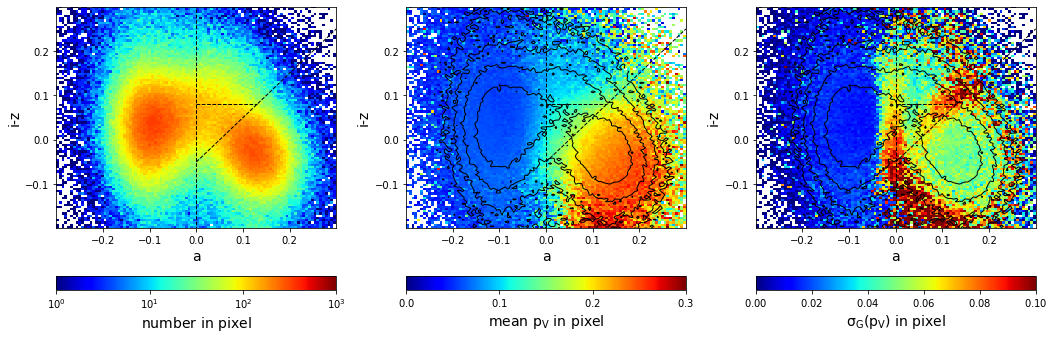

In [49]:
vpt.XDcontourplot(dataOKfull['a_color'], dataOKfull['i-z'], dataOKfull['pV'])

58 values are outside the defined minimum and maximum.
mu : 0.993
sigma : 0.165
weight : 1.000

35 values are outside the defined minimum and maximum.
mu : 1.002
sigma : 0.149
weight : 1.000

saved plot as: MMIvsXDhist.png


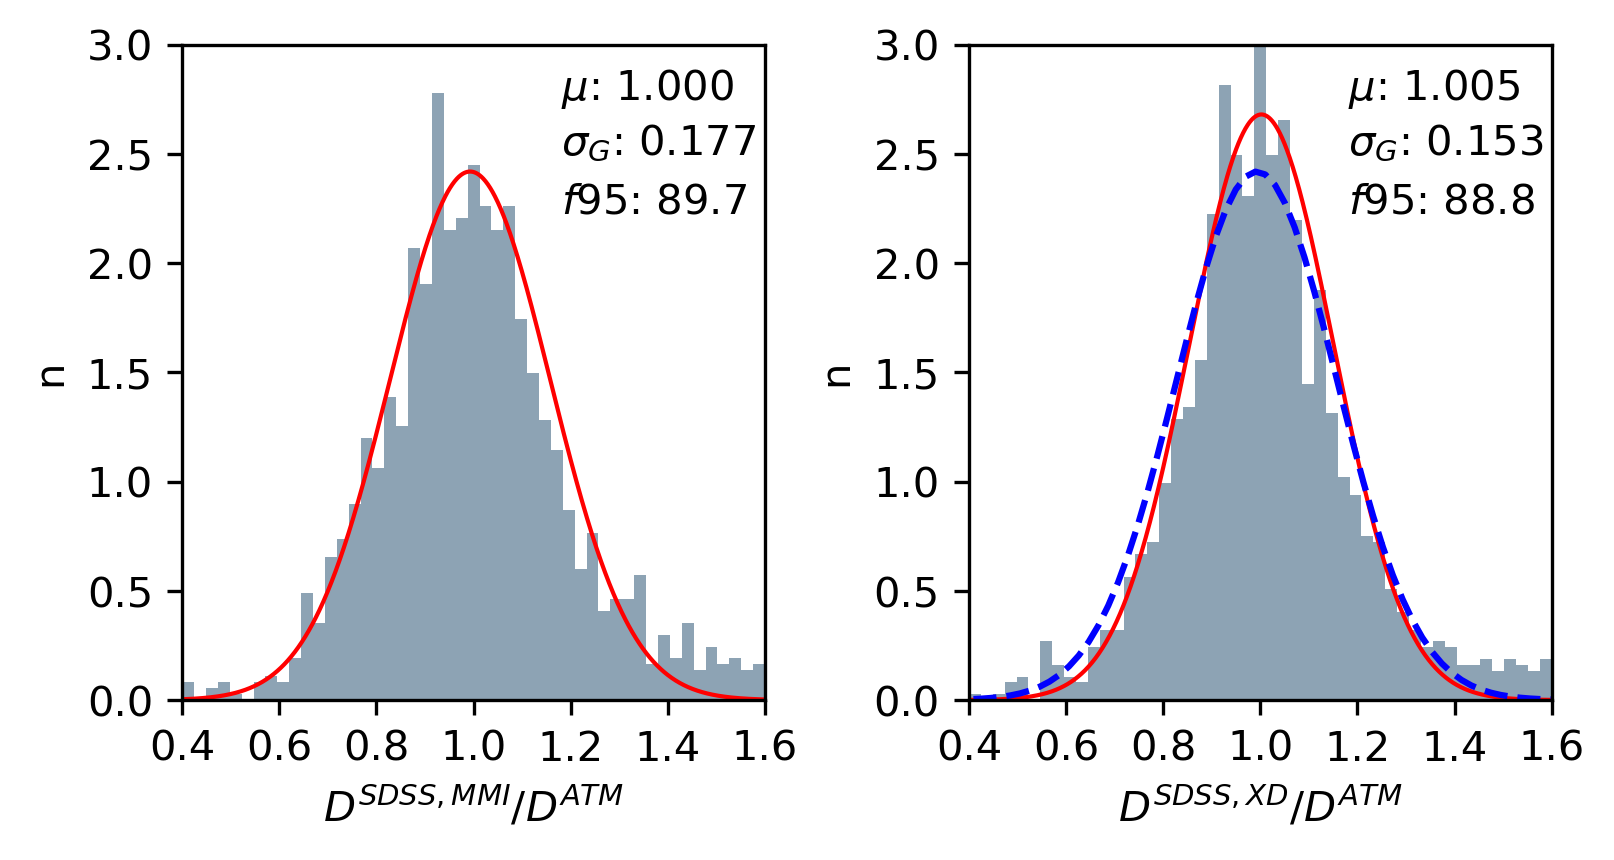

In [50]:
DratMMI = np.sqrt(data['pV']/data['pMMI'])
DratXD = np.sqrt(data['pVratXD'])
vpt.histCompare(DratMMI, DratXD)